# Cleland/Mount Lagoon Koala faecal 16S rRNA gene analysis (v4)

## Raphael Eisenhofer, December 2020##

In [1]:
conda activate qiime2-2020.6

(qiime2-2020.6) 

: 1

In [3]:
cd 2020_KoalaCleland

(qiime2-2020.6) 

: 1

###    Import reads

In [12]:
qiime tools import \
--type SampleData[SequencesWithQuality] \
--input-path manifesto.txt \
--input-format SingleEndFastqManifestPhred33V2 \
--output-path demux-r1.qza

Imported manifesto.txt as SingleEndFastqManifestPhred33V2 to demux-r1.qza
(qiime2-2020.6) 

: 1

In [13]:
qiime demux summarize \
--i-data demux-r1.qza \
--o-visualization demux-r1.qzv

Saved Visualization to: demux-r1.qzv
(qiime2-2020.6) 

: 1

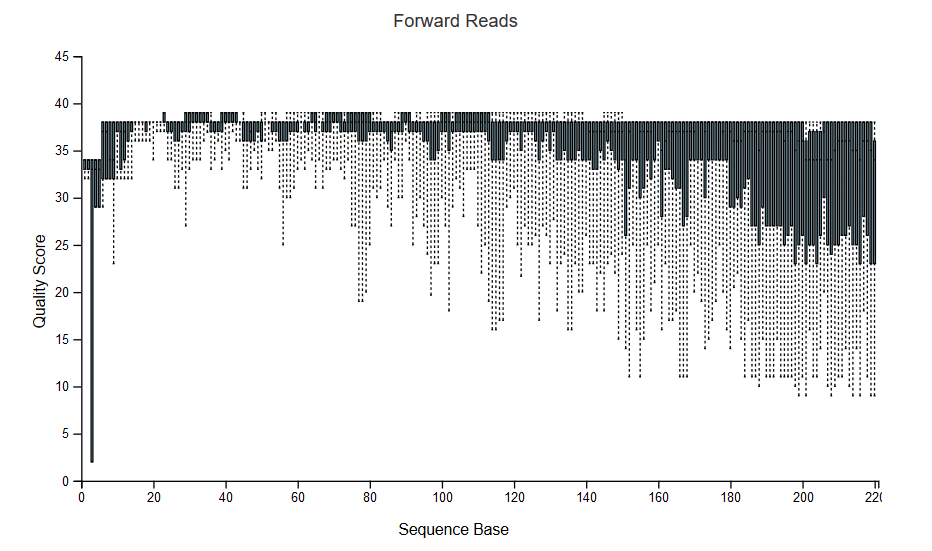

Qualities look mostly good (something funky on position 3, but shouldn't be an issue), will trim at 150 bp.

In [14]:
qiime deblur denoise-16S \
--i-demultiplexed-seqs demux-r1.qza \
--p-trim-length 150 \
--p-sample-stats \
--o-representative-sequences Koala-rep-seqs.qza \
--o-table Koala-table.qza \
--o-stats Koala-deblur-stats.qza \
--verbose \
--p-jobs-to-start 6

Saved FeatureTable[Frequency] to: Koala-table.qza
Saved FeatureData[Sequence] to: Koala-rep-seqs.qza
Saved DeblurStats to: Koala-deblur-stats.qza
(qiime2-2020.6) 

: 1

In [15]:
qiime feature-table tabulate-seqs \
--i-data Koala-rep-seqs.qza \
--o-visualization Koala-rep-seqs.qzv

Saved Visualization to: Koala-rep-seqs.qzv
(qiime2-2020.6) 

: 1

In [16]:
qiime feature-table summarize \
--i-table Koala-table.qza \
--o-visualization Koala-table.qzv

Saved Visualization to: Koala-table.qzv
(qiime2-2020.6) 

: 1

###    Assign taxonomy using a naive bayesian classifier against the SILVA 138 v4 database:

In [ ]:
qiime feature-classifier classify-sklearn \
--i-reads Koala-rep-seqs.qza \
--i-classifier silva-138-99-515-806-nb-classifier.qza \
--o-classification Koala-SILVA-138.qza \
--p-n-jobs 16

In [17]:
qiime metadata tabulate \
--m-input-file Koala-SILVA-138.qza \
--o-visualization Koala-SILVA-138.qzv

Saved Visualization to: Koala-SILVA-138.qzv
(qiime2-2020.6) 

: 1

### Create a phylogenetic tree using SEPP: 

In [ ]:
qiime fragment-insertion sepp \
--i-representative-sequences Koala-rep-seqs.qza \
--i-reference-database sepp-refs-silva-128.qza \
--o-tree Koala-sepp-tree.qza \
--o-placements Koala-sepp-placements.qza \
--verbose \
--p-threads 16 

### Filter out features that couldn't be inserted on tree:

In [19]:
qiime fragment-insertion filter-features \
  --i-table Koala-table.qza \
  --i-tree Koala-sepp-tree.qza \
  --o-filtered-table Koala-filtered_table.qza \
  --o-removed-table Koala-removed_table.qza \
  --verbose

Saved FeatureTable[Frequency] to: Koala-filtered_table.qza
Saved FeatureTable[Frequency] to: Koala-removed_table.qza
(qiime2-2020.6) 

: 1

In [20]:
qiime feature-table summarize \
--i-table Koala-removed_table.qza \
--o-visualization Koala-removed_table.qzv

Saved Visualization to: Koala-removed_table.qzv
(qiime2-2020.6) 

: 1

### Looks like nothing was removed, so will just use the unfiltered table (table.qza) for subsequent analyses.

### Run alpha-rarefaction analysis to see what a good sampling depth will be:

In [22]:
qiime diversity alpha-rarefaction \
--i-table Koala-table.qza \
--m-metadata-file Koala_Metadata.tsv \
--o-visualization table-rarefaction.qzv \
--p-min-depth 500 \
--p-max-depth 50000

Saved Visualization to: table-rarefaction.qzv
(qiime2-2020.6) 

: 1

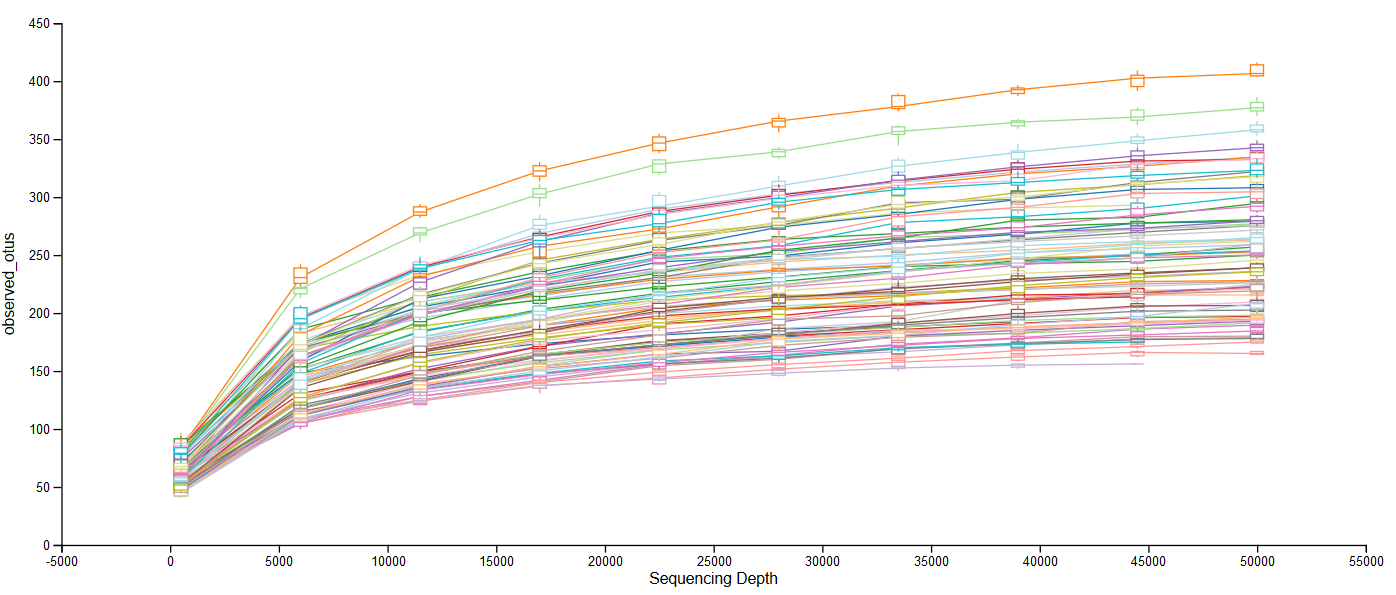

Diversity seems to plateau ~30,000 sequences. The same with the lowset # of sequences = Cleland-R46, with 32244 sequences.

Let's set the rarefaction depth to 32,244  to keep all of our samples :-)

In [24]:
qiime diversity core-metrics-phylogenetic \
--i-table Koala-table.qza \
--i-phylogeny Koala-sepp-tree.qza \
--p-sampling-depth 32244 \
--m-metadata-file Koala_Metadata.tsv \
--output-dir Core-metrics-both-populations-32244

Saved FeatureTable[Frequency] to: Core-metrics-both-populations-32244/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Core-metrics-both-populations-32244/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: Core-metrics-both-populations-32244/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Core-metrics-both-populations-32244/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Core-metrics-both-populations-32244/evenness_vector.qza
Saved DistanceMatrix to: Core-metrics-both-populations-32244/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: Core-metrics-both-populations-32244/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: Core-metrics-both-populations-32244/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Core-metrics-both-populations-32244/bray_curtis_distance_matrix.qza
Saved PCoAResults to: Core-metrics-both-populations-32244/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: Core-metrics-both-populations-32244

: 1

### Loop through alpha diversity files and compute significance

In [26]:
for i in Core-metrics-both-populations-32244/*vector.qza; \
do qiime diversity alpha-group-significance \
--i-alpha-diversity $i \
--m-metadata-file Koala_Metadata.tsv \
--o-visualization ${i/.qza/.qzv}; 
done

Saved Visualization to: Core-metrics-both-populations-32244/evenness_vector.qzv
Saved Visualization to: Core-metrics-both-populations-32244/faith_pd_vector.qzv
Saved Visualization to: Core-metrics-both-populations-32244/observed_features_vector.qzv
Saved Visualization to: Core-metrics-both-populations-32244/shannon_vector.qzv
(qiime2-2020.6) 

: 1

### Make some taxa bar plots:

In [25]:
qiime taxa barplot \
--i-table Koala-table.qza \
--i-taxonomy Koala-SILVA-138.qza \
--m-metadata-file Koala_Metadata.tsv \
--o-visualization Koala-table-BarPlots-by-sample.qzv

Saved Visualization to: Koala-table-BarPlots-by-sample.qzv
(qiime2-2020.6) 

: 1